In [20]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage
import re

import tensorflow as tf
from tensorflow import keras

In [23]:
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

In [6]:
df = pd.read_csv('./Text Data/IMDB Dataset.csv')

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [34]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df['sentiment'].value_counts()
#긍정과 부정이 각 25000개씩 분포되어있음

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [13]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()
#preprocessing을 사용하여 positive를 1, negative를 0으로 변환 

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


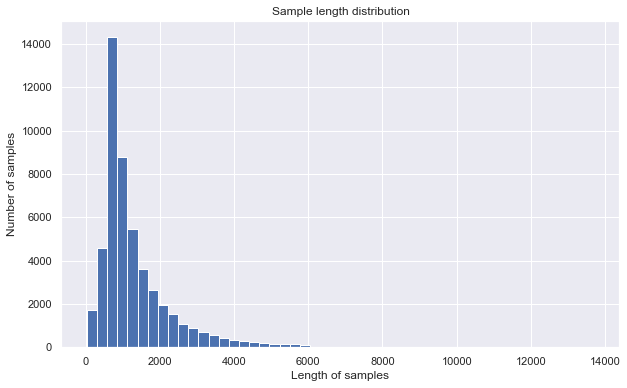

In [16]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(df['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()
#4000개까지가 대부분의 review의 길이이며 대다수가 4000개미만으로 분포되어있다

### 분석에 전처리가 없어 전처리과정만 추가하였습니다

In [17]:
def review_to_wordlist(review, remove_stopwords = True):

    
    review_text = re.sub('[^a-zA-Z]'," ", review)
    #review_text에 영어만 넣기 
    
    words = review_text.lower().split()
    #소문자로 바꿔주고 그것들을 분리해준다 
    
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        #stops에 영어의 불용어를 넣어줌 
        #words는 소문자로 변환되고 띄어져있는 것이며 
        #stops에 있는 불용어를 제외하고 넣어줌 
        
    b = []
    stemmer = english_stemmer
    for word in words:
        b.append(stemmer.stem(word))
        #words에 전처리된것들의 어간들만 추출 
        
    return(b)

In [24]:
clean_reviews = []
for review in df['review']:
    clean_reviews.append( " ".join(review_to_wordlist(review)))

In [33]:
type(clean_reviews)

list

In [35]:
clean_reviews = pd.DataFrame(clean_reviews)

In [36]:
df1 = pd.concat([clean_reviews,df['sentiment']], axis =1 )

In [38]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [37]:
df1
#분석에 필요없는 단어들(불용어)들이 삭제된것을 볼 수 있다.

,0,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product br br film techniqu unass...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49995,thought movi right good job creativ origin fir...,1
49996,bad plot bad dialogu bad act idiot direct anno...,0
49997,cathol taught parochi elementari school nun ta...,0
49998,go disagre previous comment side maltin one se...,0


In [42]:
Data = df1.rename({0: 'review'}, axis = 'columns')
Data
#컬럼명을 0에서 review로 변경 

,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product br br film techniqu unass...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49995,thought movi right good job creativ origin fir...,1
49996,bad plot bad dialogu bad act idiot direct anno...,0
49997,cathol taught parochi elementari school nun ta...,0
49998,go disagre previous comment side maltin one se...,0


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

In [46]:
def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        #strip_accents : 전처리에서 악센트를 제거하고 문자들을 정규화
        'decode_error' : 'replace',
        #문자를 포함하는 분석을 위해 바이트 시퀀스가 제공되는 경우 수행
        'analyzer' : TOKEN_MODE,
        'min_df': MIN_DOC_FREQ,
    }
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    # *왜 들어가는 지 모르겠음 
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    #transformed_text에 tfidf벡터화로 변환한것을 추가 
    
    selector = SelectKBest(f_classif, k = min(TOP_K, transformed_texts.shape[1]))
    #20000만개
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
    #selectKBest : 성능이 좋은 변수만 사용하는 전처리기
    #f_classif : 분산분석 F검정 통계값

vect_data = ngram_vectorize(Data['review'], Data['sentiment'])

In [50]:
vect_data

<50000x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 3971088 stored elements in Compressed Sparse Row format>

#### ================ 위의 함수 예시 =================

In [53]:
SData = Data[1:10]
SData

,review,sentiment
1,wonder littl product br br film techniqu unass...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1
5,probabl time favorit movi stori selfless sacri...,1
6,sure would like see resurrect date seahunt ser...,1
7,show amaz fresh innov idea first air first yea...,0
8,encourag posit comment film look forward watch...,0
9,like origin gut wrench laughter like movi youn...,1


In [54]:
vect_data1 = ngram_vectorize(SData['review'], SData['sentiment'])
vect_data1

<9x70 sparse matrix of type '<class 'numpy.float32'>'
	with 200 stored elements in Compressed Sparse Row format>

In [58]:
print(vect_data1)
#각각의 추출된 단어들이 tfidf로 잘변환된것을 볼 수 있다.

  (0, 8)	0.5199556
  (0, 9)	0.2599778
  (0, 14)	0.15615065
  (0, 15)	0.15615065
  (0, 16)	0.15615065
  (0, 18)	0.13576849
  (0, 19)	0.15615065
  (0, 21)	0.11995885
  (0, 25)	0.13576849
  (0, 27)	0.15615065
  (0, 28)	0.13576849
  (0, 30)	0.15615065
  (0, 32)	0.3123013
  (0, 37)	0.15615065
  (0, 42)	0.13576849
  (0, 43)	0.09611991
  (0, 46)	0.11995885
  (0, 47)	0.11995885
  (0, 50)	0.15615065
  (0, 52)	0.08665927
  (0, 57)	0.11995885
  (0, 58)	0.08665927
  (0, 60)	0.11995885
  (0, 62)	0.09611991
  (0, 64)	0.40730545
  :	:
  (7, 25)	0.12635632
  (7, 33)	0.29065096
  (7, 35)	0.11164268
  (7, 43)	0.17891277
  (7, 45)	0.14532548
  (7, 46)	0.11164268
  (7, 47)	0.11164268
  (7, 52)	0.080651596
  (7, 53)	0.14532548
  (7, 54)	0.14532548
  (7, 57)	0.11164268
  (7, 58)	0.080651596
  (7, 60)	0.11164268
  (7, 62)	0.08945639
  (7, 63)	0.11164268
  (8, 8)	0.2966548
  (8, 9)	0.1483274
  (8, 17)	0.26726997
  (8, 28)	0.23238353
  (8, 31)	0.6159705
  (8, 34)	0.23238353
  (8, 38)	0.3664277
  (8, 42)	0.2323

#### =====================================

In [63]:
vect_data.shape

(50000, 20000)

In [62]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(Data['review'])
tr_texts.shape
###위에서 만든함수를 사용하여 tfidf변환을 했을때와 tfidf함수에 그냥 넣었을때를 비교해보면 확실하게 컬럼의 수가 줄어든것을 볼 수 있다.

(50000, 68190)

In [66]:
from sklearn.model_selection import train_test_split

X = vect_data.toarray()
y = (np.array(Data['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=13)
#X를 toarray로 변환하는 이유를 모르겠음 

In [67]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [68]:
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [77]:
DROPOUT_RATE = 0.2
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = X_train.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)
#클래스가 2이므로 unit은 1이고 활성화함수는 sigmoid

In [102]:
model = keras.Sequential()
model.add(Dropout(rate = 0.3, input_shape = input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units = UNITS, activation = 'relu'))
    model.add(Dropout(rate = 0.3))
    
model.add(Dense(units = op_units, activation = op_activation))
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_14 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                1280064   
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [103]:
LEARNING_RATE = 1e-3

if NUM_CLASSES == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
#2진분류이므로 binary_crossentropy사용 
#sparse_categorical_crossentropy : 다중 분류 손실함수이지만 정수 값을 그대로 줄 수 있음
#현재는 NUM_CLASSES가 2이므로 binary_crossentropy를 사용
#이렇게 if문을 사용하면 다른 모델에 적용할때 사용할 수 있을것 같음

In [104]:
EPOCHS = 20
BATCH_SIZE = 126

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=2)]

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    verbose=1, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks)
#기존의 코드에서는 6번의 학습에서 early stop이 되었음
#dropout을 다르게 지정하였을때 0.3과 0.5지정을 하였고 12번의 학습을 수행
#dropout을 다르게 지정하였을때 0.3과 0.3지정을 하였고 8번의 학습을 수행
#val_loss는 0.18..정도가 최대

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 9s 236us/sample - loss: 0.4516 - acc: 0.8482 - val_loss: 0.2771 - val_acc: 0.9042
Epoch 2/20
40000/40000 [==============================] - 9s 225us/sample - loss: 0.2460 - acc: 0.9060 - val_loss: 0.2181 - val_acc: 0.9174
Epoch 3/20
40000/40000 [==============================] - 8s 194us/sample - loss: 0.2012 - acc: 0.9222 - val_loss: 0.2012 - val_acc: 0.9206
Epoch 4/20
40000/40000 [==============================] - 8s 202us/sample - loss: 0.1792 - acc: 0.9280 - val_loss: 0.1942 - val_acc: 0.9218
Epoch 5/20
40000/40000 [==============================] - 8s 207us/sample - loss: 0.1607 - acc: 0.9380 - val_loss: 0.1903 - val_acc: 0.9245
Epoch 6/20
40000/40000 [==============================] - 11s 279us/sample - loss: 0.1472 - acc: 0.9430 - val_loss: 0.1886 - val_acc: 0.9265
Epoch 7/20
40000/40000 [==============================] - 10s 243us/sample - loss: 0.1353 - acc: 0.9479 - val

In [107]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
#test loss와 test accuracy가 약 0.19, 0.93정도로 비교적 좋은 성는을 보여준다


10000/10000 [==============================] - 1s 66us/sample - loss: 0.1894 - acc: 0.9256
Test loss: 0.18937663137316704
Test accuracy: 0.9256


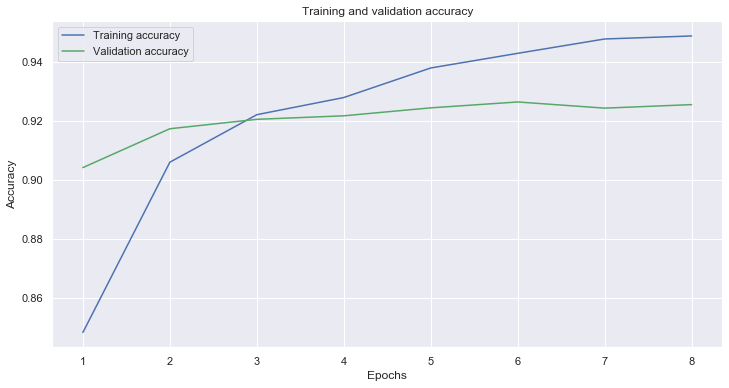

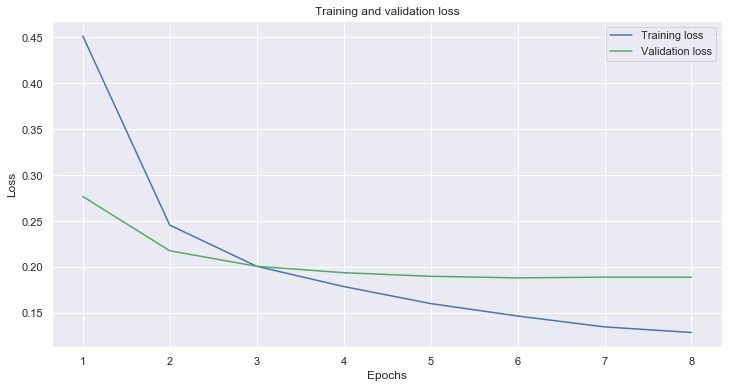

In [108]:
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # 정확도 표시 
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 손실율 표시
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

### 참조 : https://www.kaggle.com/irinaabdullaeva/imdb-reviews-with-keras